<a href="https://colab.research.google.com/github/ahmedmusawir/modern-agents-youtube-series/blob/main/AGENTS_Reflection_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### INSTALLATIONS

In [ ]:
!pip install -q langchain
!pip install -q langchain_openai
!pip install -q langchain_community
!pip install -q langgraph
!pip install -q langchain-anthropic

!pip show langchain
!pip show langgraph


Name: langchain
Version: 0.3.9
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community
Name: langgraph
Version: 0.2.53
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 


### LOADING API KEY

In [ ]:
import os
os.environ["OPENAI_API_KEY"] ="sk-proj-ulX3zM****************8CUAYWg7y8Ge8pROt"
os.environ["ANTHROPIC_API_KEY"]="sk-ant-api03-Sf********cjpHlXZEl8-IqYrs4bmmTp3hDmAaVang-IsYoZAAA"

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"REFLECTION AGENT ORCHESTRATION"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "lsv2_pt_4ce944820*********cd65c_37d096d1b5"

### TESTING THE MODEL RESPONSE

In [ ]:
from langchain_openai import ChatOpenAI
import pprint

# Create an instance of the OpenAI class
llm = ChatOpenAI(model="gpt-4o")
# llm = ChatOpenAI(model="o1-mini")
# llm = ChatOpenAI(model="o1-preview")

# Generate text
prompt = "Who is Alan Watts (in one sentence)"
response = llm.invoke(prompt)
# print(response)
pprint.pprint(response.content)

('Alan Watts was a British philosopher, writer, and speaker known for '
 'interpreting and popularizing Eastern philosophy for Western audiences.')


# REFLECTION AGENT ORCHESTRATION

## STEP 1: GENERATE

In [ ]:
# importing the necessary libraries
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
import pprint

### BUILD GENERATE PROMPT & CHAIN
(Twitter Expert)

In [ ]:
# Creating a chat prompt template
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter expert assigned to craft outstanding tweets.
            Generate the most engaging and impactful tweet possible based on the user's request.
            If the user provides feedback, refine and enhance your previous attempts accordingly for maximum engagement.''',
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)
# Create the model object
openai_llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.7)

# Using LCEL to create the generate_chain
generate_chain  = generation_prompt | openai_llm

generate_chain


### TESTING GENERATE CHAIN

In [ ]:
tweet = ''
request = HumanMessage(
    content='U.S.A. Election 2024'
)

result = generate_chain.invoke({'messages': [request]})
pprint.pprint(result.content)


('🇺🇸 The countdown to #Election2024 is on! 🗳️ Are you ready to make your voice '
 'heard? Let’s shape the future together—every vote counts! 🗽✨ What issues '
 'matter most to you this election season? #Vote2024 #YourVoteMatters')


## STEP 2: REFLECTION

### REFLECTION PROMPT & CHAIN
(Tweeter Critique)

In [ ]:
from langchain_anthropic import ChatAnthropic

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter influencer known for your engaging content and sharp insights.
            Review and critique the user’s tweet.
            Provide constructive feedback, focusing on enhancing its depth, style, and overall impact.
            Offer specific suggestions to make the tweet more compelling and engaging for their audience.'''
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)
# Create the model object
claude_llm = ChatAnthropic(
    model="claude-3-5-sonnet-20240620",
    temperature=0,
)
# Using LCEL to create the generate_chain
reflect_chain  = reflection_prompt | claude_llm

reflect_chain

### TESTING THE REFLECTION CHAIN

In [ ]:
reflection = ''
# streaming the response
for chunk in reflect_chain.stream(
    {'messages': [request, HumanMessage(content=tweet)]}
):
    print(chunk.content, end='')
    reflection += chunk.content


Thank you for sharing your tweet idea. While it's concise and touches on a significant topic, there's room for improvement to make it more engaging and impactful. Here's my critique and some suggestions:

1. Lack of specificity: The tweet is too vague and doesn't provide any unique insight or perspective on the 2024 U.S. election.

2. Missing hook: There's no element to grab the reader's attention or encourage engagement.

3. No call to action: The tweet doesn't prompt the audience to think, discuss, or take any action.

Here are some suggestions to improve the tweet:

1. Add a thought-provoking question or statement:
"U.S.A. Election 2024: Will it be a battle of policies or personalities? The stakes have never been higher. #Election2024"

2. Incorporate a relevant statistic or fact:
"Did you know? In 2020, 155 million Americans voted - the highest turnout in over a century. What will 2024 bring? #USAElection2024"

3. Offer a unique perspective or prediction:
"U.S.A. Election 2024: The

## STEP 3: THE GRAPH

In [ ]:
from typing import List, Sequence
from langgraph.graph import END, MessageGraph

### DEFINE THE GRAPH

In [ ]:
from langchain_core.messages import BaseMessage

# defining a function for the generation node
def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({'messages': state})

# defining a function for the reflection node
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # messages we need to adjust
    cls_map = {'ai': HumanMessage, 'human': AIMessage}
    # First message is the original user request. We keep it the same for all nodes
    translated = [messages[0]] + [
    cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = reflect_chain.invoke({'messages': translated})
    # We treat the output (AI message) of this as human feedback for the generator
    return HumanMessage(content=res.content)

# initializing the MessageGraph and adding two nodes to the graph: generate and reflect.
builder = MessageGraph()
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)

# setting the generate node as the starting point
builder.set_entry_point('generate')

# define our conditional edge function
MAX_ITERATIONS = 5
def should_continue(state: List[BaseMessage]):
    if len(state) > MAX_ITERATIONS:
        return END
    return 'reflect'

# adding a conditional edge to the graph
builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

# compiling the graph
graph = builder.compile()

### VIEW THE GRAPH

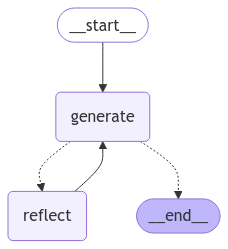

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## STEP 4: RUNNING THE GRAPH

In [ ]:
inputs = HumanMessage(content='Generate a tweet about FIFA World Cup 2026')
response = graph.invoke(inputs)

for resp in response:
    print(resp.content)
    # pprint.pprint(resp.content)
    print('\n' + '-' * 100 + '\n')

Generate a tweet about FIFA World Cup 2026

----------------------------------------------------------------------------------------------------

🏆⚽️ Excitement is building for the #FIFAWorldCup2026! 🌍🇺🇸🇨🇦🇲🇽 With three nations coming together, we’re set for a historic tournament filled with unforgettable moments! Who are you cheering for? Let the countdown to glory begin! ⏳✨ #WorldCup2026 #SoccerLove

----------------------------------------------------------------------------------------------------

Your tweet about the FIFA World Cup 2026 is a good start, but there's room for improvement to make it more engaging and impactful. Here's my critique and suggestions:

1. Content: The tweet covers the basics - excitement, host nations, and a call for engagement. However, it lacks specific details that could make it more informative and interesting.

2. Hashtags: You've used relevant hashtags, which is good. However, consider using more specific ones to increase reach.

3. Emojis: The use 